## Importing Libraries

In [1]:
import numpy as np
import os
import pandas as pd

from scipy.stats import gmean

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Local module
from pathway_modules import PathwayAnalysis

## Reading all the data

#### Reading sample info and genes IDs
* Editing columns for better call
* Filtering samples in sample variable
* Read the ensemble IDs file

In [2]:
sample_path = os.path.join('data_external', 'melanoma_data', 'metadata.csv')
sample_info = pd.read_csv(sample_path)

sample_info = sample_info[sample_info['Sample Type'] != 'Additional Metastatic']
sample_primary = sample_info[sample_info['Sample Type'] != 'Metastatic']
sample_metastatic = sample_info[sample_info['Sample Type'] != 'Solid Tissue Normal']

print(sample_info['Sample Type'].value_counts(), '\n')
print(sample_primary['Sample Type'].value_counts(), '\n')
print(sample_metastatic['Sample Type'].value_counts())

Sample Type
Metastatic             367
Primary Tumor          103
Solid Tissue Normal      1
Name: count, dtype: int64 

Sample Type
Primary Tumor          103
Solid Tissue Normal      1
Name: count, dtype: int64 

Sample Type
Metastatic       367
Primary Tumor    103
Name: count, dtype: int64


#### Read the expression data sample files

In [3]:
data_path = os.path.join('data_external', 'melanoma_data', 'melanoma_data.csv')
data = pd.read_csv(data_path, index_col=0)
data

,TCGA-DA-A95Z-06A,TCGA-GN-A8LL-06A,TCGA-D3-A8GM-06A,TCGA-EE-A2GN-06A,TCGA-FR-A729-06A,TCGA-EE-A29G-06A,TCGA-EE-A2MF-06A,TCGA-WE-A8K6-06A,TCGA-EE-A2MT-06A,TCGA-FR-A8YC-06A,...,TCGA-EE-A2GT-06A,TCGA-EE-A3AG-06A,TCGA-EE-A180-06A,TCGA-EE-A2MG-06A,TCGA-EE-A29A-06A,TCGA-EB-A5VU-01A,TCGA-ER-A19A-06A,TCGA-DA-A1I2-06A,TCGA-EE-A3J4-06A,TCGA-EB-A85I-01A
ensembl,,,,,,,,,,,,,,,,,,,,,
ENSG00000242268,0.000000,0.000000,0.000000,0.000000,0.000000,0.024334,0.060759,0.076233,0.056575,0.329233,...,0.031685,0.097396,0.414272,0.023063,0.000000,1.357993,0.000000,0.000000,0.021370,0.032211
ENSG00000270112,0.006567,0.000000,0.000000,0.002907,0.000000,0.000000,0.000000,0.208024,0.000000,0.005076,...,0.000000,0.013514,0.000000,0.006400,0.244848,0.000000,0.000000,0.002317,0.000000,0.022347
ENSG00000167578,4.446591,5.460279,2.613384,1.182421,3.984613,2.703277,4.035968,6.392728,3.979068,2.876344,...,6.245538,3.414527,4.934416,5.277949,4.942260,2.518981,3.698142,2.773270,2.497361,11.937246
ENSG00000273842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000078237,8.147431,5.109451,13.420310,7.325709,7.480842,4.886559,13.200054,4.846133,15.333803,3.720228,...,7.813871,3.358053,15.465819,6.012482,4.358013,12.879360,5.974398,11.674508,10.339529,5.204848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000105063,23.270227,19.345656,33.596851,20.218259,19.486246,17.495109,19.781692,15.169497,34.383673,19.585185,...,34.269326,45.322763,28.080770,28.403588,28.577022,18.698618,31.956733,21.592017,21.903251,14.319962
ENSG00000231119,0.130021,0.168018,0.190540,0.032886,0.319995,0.219667,0.071541,0.438825,0.088819,0.201006,...,0.000000,0.259938,0.201307,0.235344,0.136418,0.541448,0.014283,0.242472,0.117425,0.063210
ENSG00000280861,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Top Pathways in Primary Tumor

In [4]:
top_pathway_path = os.path.join('data_external', 'data_pathways', 'Top_pathways.csv')
top_primary_pathw = PathwayAnalysis(pathway_file=top_pathway_path)
top_primary_matrix = top_primary_pathw.pathway_expression(
    gene_expression=data[sample_primary['Sample ID']],
    metadata=sample_primary,
    normal_label='Solid Tissue Normal'
)
top_primary_matrix

,TCGA-BF-A5ES-01A,TCGA-GF-A2C7-01A,TCGA-BF-AAP1-01A,TCGA-EB-A6R0-01A,TCGA-EB-A41B-01A,TCGA-EB-A3HV-01A,TCGA-EB-A5SF-01A,TCGA-BF-A1PZ-01A,TCGA-BF-A3DL-01A,TCGA-EB-A553-01A,...,TCGA-ER-A2NB-01A,TCGA-EB-A3XD-01A,TCGA-BF-AAP6-01A,TCGA-EB-A551-01A,TCGA-EB-A42Z-01A,TCGA-FR-A2OS-01A,TCGA-EB-A3XF-01A,TCGA-XV-A9W5-01A,TCGA-EB-A5VU-01A,TCGA-EB-A85I-01A
Autophagy,0.800064,0.649246,0.651014,0.643057,0.695806,0.764258,1.414124,0.754215,0.977747,1.210642,...,1.398353,0.856870,0.620656,0.628541,0.614913,0.572366,0.493112,0.549483,0.570039,0.657223
Cell Cycle,0.936387,0.629904,0.630747,0.684490,0.815462,0.995414,1.910272,0.735453,1.188430,1.364761,...,1.859597,1.180947,0.626124,0.612697,0.621356,0.604303,0.537147,0.526963,0.601073,0.814088
Cell-Cell communication,1.002613,1.081007,1.132052,0.966627,1.114543,1.097074,1.935421,0.924089,1.198855,1.490968,...,1.831493,1.367685,0.994020,0.888230,0.839881,1.128240,0.964820,1.119258,1.083846,0.890275
Cellular responses to stimuli,0.914700,0.737262,0.750989,0.746760,0.898505,0.832954,1.553291,0.783204,1.078080,1.303400,...,1.426417,0.943007,0.749430,0.729836,0.718613,0.741539,0.677219,0.731407,0.725970,0.847348
Chromatin organization,0.725286,0.773884,0.833652,1.242933,1.273344,0.769551,1.205879,1.319999,0.972109,1.378045,...,1.056877,1.381993,0.994884,0.722833,0.910383,0.827431,0.980641,0.618715,0.652601,1.080555
Circadian Clock,0.775107,0.617016,0.823239,0.706088,0.738931,0.685284,1.375668,0.661162,1.028406,1.408700,...,1.297817,0.931502,0.547358,0.550743,0.584125,0.617573,0.589744,0.750262,0.708210,0.829472
DNA Repair,0.834150,0.628301,0.652953,0.720880,0.746141,0.837976,1.639787,0.800103,1.065806,1.394534,...,1.586330,1.066548,0.632431,0.656049,0.614405,0.615205,0.570692,0.511855,0.577561,0.779496
DNA Replication,0.652556,0.642296,0.602201,0.657762,0.696503,0.805815,1.491978,0.694741,0.920708,1.232083,...,1.402270,0.940148,0.558711,0.618863,0.593042,0.556569,0.488793,0.492532,0.601016,0.728565
Developmental Biology,1.032853,1.179733,0.980876,0.916905,1.015988,1.317140,1.847594,0.973931,1.140633,1.244144,...,1.669638,1.599303,0.957483,0.883722,0.936768,0.943914,0.955040,1.101854,1.208147,0.917051
Digestion and absorption,0.726253,0.663707,0.695033,0.723815,0.980646,0.667904,0.812901,0.584083,0.647565,0.770786,...,0.639444,0.822567,0.524211,0.585775,0.592715,0.516119,0.644488,0.677164,0.768141,0.601726


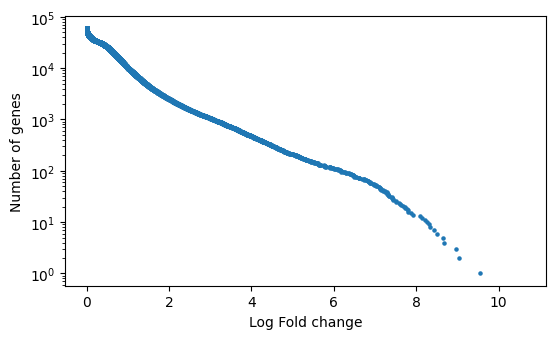

In [5]:
x = top_primary_pathw.fold_change.abs().mean(axis=1).sort_values(ascending=False).to_numpy()
y = range(x.size)

fig_height = 3.5
fig_width = fig_height * 1.618
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
plt.scatter(x=x, y=y, s=5)
plt.yscale('log')
plt.xlabel('Log Fold change')
plt.ylabel('Number of genes')
plt.tight_layout()


(0.28626182464648825, 2.2224074989864877)

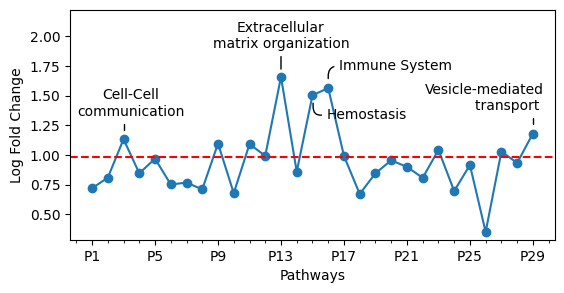

In [6]:
y = top_primary_pathw.pathway_data.mean(axis=1).to_numpy()
x = [f'P{i}' for i in range(1, 30)]

top_primary_fc = top_primary_pathw.fold_change.loc[top_primary_pathw.common_genes]
top_primary_ref = top_primary_fc.abs().mean(axis=None)

fig_height = 3.5
fig_width = fig_height * 1.618
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
plt.plot(x, y, 'o-')
plt.axhline(top_primary_ref, color='red', linestyle='dashed')

ax.set_xticks([x[i] for i in range(0, len(x), 4)])
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

ax.annotate('Cell-Cell\ncommunication',
            xy=(2, 1.19),
            xytext=(5, 10),
            textcoords='offset points',
            ha='center', va='bottom',
            arrowprops = dict(facecolor='k',
                              arrowstyle = "-",
                              connectionstyle="angle,angleA=0,angleB=90,rad=10")
            )

ax.annotate('Extracellular\nmatrix organization',
            xy=(12, 1.7),
            xytext=(0, 15),
            textcoords='offset points',
            ha='center', va='bottom',
            arrowprops = dict(facecolor='k',
                              arrowstyle = "-",)
            )

ax.annotate('\nHemostasis',
            xy=(14.04, 1.46),
            xytext=(10, 6),
            textcoords='offset points',
            ha='left', va='top',
            arrowprops=dict(facecolor='k',
                            arrowstyle="-",
                            connectionstyle="angle,angleA=190,angleB=90,rad=10"))

ax.annotate('Immune System',
            xy=(15, 1.62),
            xytext=(8, 6),
            textcoords='offset points',
            ha='left', va='bottom',
            arrowprops = dict(facecolor='k',
                              arrowstyle = "-",
                              connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate('Vesicle-mediated\ntransport ',
            xy=(28, 1.24),
            xytext=(8, 10),
            textcoords='offset points',
            ha='right', va='bottom',
            arrowprops = dict(facecolor='k',
                              arrowstyle = "-",
                              connectionstyle="angle,angleA=0,angleB=90,rad=10"))

plt.ylabel('Log Fold Change')
plt.xlabel('Pathways')
plt.tight_layout()

ylim = list(plt.ylim())
ylim[1] += 0.5
plt.ylim(ylim)


## Top Pathways in Metastatic Tumor

In [7]:
top_pathway_path = os.path.join('data_external', 'data_pathways', 'Top_pathways.csv')
top_metastatic_pathw = PathwayAnalysis(pathway_file=top_pathway_path)
top_metastatic_matrix = top_metastatic_pathw.pathway_expression(
    gene_expression=data[sample_metastatic['Sample ID']],
    metadata=sample_metastatic,
    normal_label='Primary Tumor'
)
top_metastatic_matrix

,TCGA-DA-A95Z-06A,TCGA-GN-A8LL-06A,TCGA-D3-A8GM-06A,TCGA-EE-A2GN-06A,TCGA-FR-A729-06A,TCGA-EE-A29G-06A,TCGA-EE-A2MF-06A,TCGA-WE-A8K6-06A,TCGA-EE-A2MT-06A,TCGA-FR-A8YC-06A,...,TCGA-ER-A2NC-06A,TCGA-D3-A5GO-06A,TCGA-EE-A2GT-06A,TCGA-EE-A3AG-06A,TCGA-EE-A180-06A,TCGA-EE-A2MG-06A,TCGA-EE-A29A-06A,TCGA-ER-A19A-06A,TCGA-DA-A1I2-06A,TCGA-EE-A3J4-06A
Autophagy,0.582539,0.925284,0.666364,0.442097,0.451566,0.497593,0.559647,0.528217,0.555407,0.529388,...,0.571252,0.469133,0.607835,0.615526,0.444571,0.512560,0.569502,0.534945,0.533835,0.430381
Cell Cycle,0.611516,0.936120,0.844987,0.486853,0.582094,0.452531,0.692722,0.756526,0.706689,0.608682,...,0.658150,0.550696,0.523827,0.919801,0.543253,0.518298,0.583664,0.504628,0.618965,0.591982
Cell-Cell communication,0.915190,1.180295,0.794502,0.741678,0.818413,1.092567,0.865613,0.991676,0.860871,0.930472,...,1.105081,0.995679,0.940815,1.165101,0.821954,0.924134,1.091606,0.989786,0.776097,0.844488
Cellular responses to stimuli,0.706870,0.976534,0.756792,0.613886,0.591422,0.564175,0.738366,0.653662,0.669497,0.662833,...,0.669545,0.647135,0.619057,0.822225,0.622459,0.595617,0.692524,0.697176,0.646363,0.637171
Chromatin organization,0.570313,0.688538,0.824157,0.480152,0.463175,0.477910,0.910175,0.648238,0.845051,0.801647,...,0.597180,0.823421,0.574627,1.045338,0.625077,0.524476,0.543994,0.436371,0.605087,0.858092
Circadian Clock,0.621184,1.144420,0.672377,0.565039,0.456323,0.707669,0.709612,0.606172,0.651383,0.597238,...,0.740779,0.602148,0.698743,0.713399,0.538932,0.626507,0.833898,0.727667,0.719210,0.576271
DNA Repair,0.611809,0.912107,0.780819,0.477643,0.543477,0.394769,0.631805,0.627144,0.684014,0.622194,...,0.555294,0.572318,0.530821,0.813677,0.464069,0.472293,0.528352,0.467979,0.588631,0.563221
DNA Replication,0.660311,0.807480,0.727778,0.426863,0.460793,0.344948,0.556439,0.637066,0.619647,0.601643,...,0.553429,0.499814,0.478620,0.831758,0.385809,0.394300,0.560596,0.421684,0.499576,0.466143
Developmental Biology,0.901292,1.092200,0.928013,0.795134,0.789248,1.304559,0.962308,0.931307,0.826935,0.900189,...,1.241029,0.916698,0.854185,1.083528,0.856523,0.842507,1.089871,0.994503,0.828443,0.910461
Digestion and absorption,0.393630,0.403206,0.287647,0.396503,0.439586,0.751782,0.445043,0.470598,0.398219,0.639135,...,0.619212,0.497095,0.454358,0.506384,0.346089,0.359560,0.522689,0.597248,0.375142,0.325621


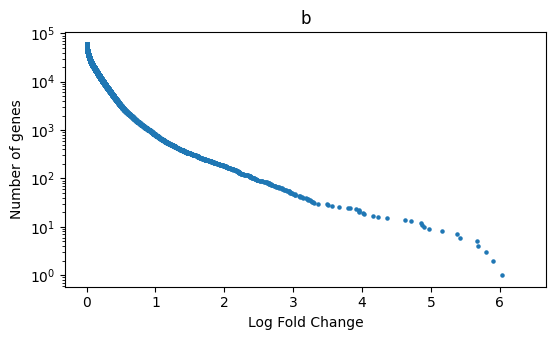

In [57]:
x = top_metastatic_pathw.fold_change.mean(axis=1).abs().sort_values(ascending=False).to_numpy()
y = range(x.size)

fig_height = 3.5
fig_width = fig_height * 1.618
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
plt.scatter(x=x, y=y, s=5)
plt.yscale('log')
plt.title('b')
plt.xlabel('Log Fold Change')
plt.ylabel('Number of genes')
plt.tight_layout()

path = os.path.join('figures_tables', 'Fig_4b.pdf')
plt.savefig(path, bbox_inches='tight')

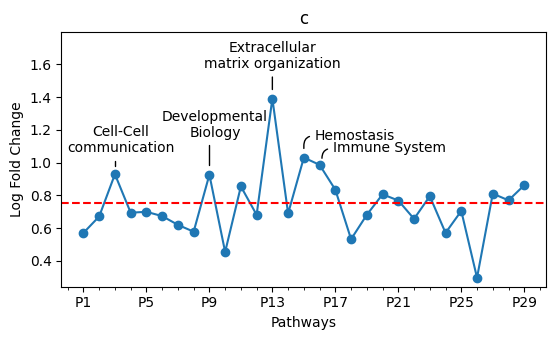

In [ ]:
y = top_metastatic_pathw.pathway_data.mean(axis=1).to_numpy()
x = [f'P{i}' for i in range(1, 30)]

top_metastatic_fc = top_metastatic_pathw.fold_change.loc[top_metastatic_pathw.common_genes]
top_metastatic_ref = top_metastatic_fc.abs().mean(axis=None)

fig_height = 3.5
fig_width = fig_height * 1.618
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
plt.plot(x, y, 'o-')
plt.axhline(top_metastatic_ref, color='red', linestyle='dashed')

ax.set_xticks([x[i] for i in range(0, len(x), 4)])
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

ax.annotate('Extracellular\nmatrix organization',
            xy=(12, 1.43),
            xytext=(0, 15),
            textcoords='offset points',
            ha='center', va='bottom',
            arrowprops = dict(facecolor='k',
                              arrowstyle = "-",)
            )

ax.annotate('Hemostasis',
            xy=(14, 1.07),
            xytext=(8, 6),
            textcoords='offset points',
            ha='left', va='bottom',
            arrowprops = dict(facecolor='k',
                              arrowstyle = "-",
                              connectionstyle="angle,angleA=0,angleB=90,rad=10")
            )

ax.annotate('Immune System',
            xy=(15.15, 1.01),
            xytext=(8, 4),
            textcoords='offset points',
            ha='left', va='bottom',
            arrowprops = dict(facecolor='k',
                              arrowstyle = "-",
                              connectionstyle="angle,angleA=0,angleB=90,rad=10")
            )

ax.annotate('Cell-Cell\ncommunication',
            xy=(2, 0.96),
            xytext=(4, 10),
            textcoords='offset points',
            ha='center', va='bottom',
            arrowprops = dict(facecolor='k',
                              arrowstyle = "-",
                              connectionstyle="angle,angleA=0,angleB=90,rad=10"
                              )
            )

ax.annotate('Developmental\nBiology',
            xy=(8, 0.97),
            xytext=(4, 20),
            textcoords='offset points',
            ha='center', va='bottom',
            arrowprops = dict(facecolor='k',
                              arrowstyle = "-",
                              connectionstyle="angle,angleA=0,angleB=90,rad=10"
                              )
            )

ylim = list(plt.ylim())
ylim[1] += 0.35
plt.ylim(ylim)

plt.title('c')
plt.ylabel('Log Fold Change')
plt.xlabel('Pathways')
plt.tight_layout()

path = os.path.join('figures_tables', 'Fig_4c.pdf')
plt.savefig(path, bbox_inches='tight')

## All Pathways in Metastatic Tumor

In [10]:
all_pathway_path = os.path.join('data_external', 'data_pathways', 'All_pathways.csv')
all_metastatic_pathw = PathwayAnalysis(pathway_file=all_pathway_path)
all_metastatic_matrix = all_metastatic_pathw.pathway_expression(
    gene_expression=data[sample_metastatic['Sample ID']],
    metadata=sample_metastatic,
    normal_label='Primary Tumor'
)
all_metastatic_matrix

,TCGA-DA-A95Z-06A,TCGA-GN-A8LL-06A,TCGA-D3-A8GM-06A,TCGA-EE-A2GN-06A,TCGA-FR-A729-06A,TCGA-EE-A29G-06A,TCGA-EE-A2MF-06A,TCGA-WE-A8K6-06A,TCGA-EE-A2MT-06A,TCGA-FR-A8YC-06A,...,TCGA-ER-A2NC-06A,TCGA-D3-A5GO-06A,TCGA-EE-A2GT-06A,TCGA-EE-A3AG-06A,TCGA-EE-A180-06A,TCGA-EE-A2MG-06A,TCGA-EE-A29A-06A,TCGA-ER-A19A-06A,TCGA-DA-A1I2-06A,TCGA-EE-A3J4-06A
2-LTR circle formation,0.547468,1.449443,0.994377,0.522776,0.496632,0.401992,0.633721,0.393974,0.431280,0.534065,...,0.690766,0.325083,0.830360,1.160678,0.506732,0.794920,0.770726,0.543841,0.534028,0.547233
3-Methylcrotonyl-CoA carboxylase deficiency,0.426184,1.072381,1.113533,0.139173,0.159540,1.007920,0.641177,0.220940,0.269469,0.123240,...,0.298782,0.093124,0.373144,0.979086,0.559483,0.411436,0.425036,0.265435,0.327004,0.678148
3-hydroxyisobutyryl-CoA hydrolase deficiency,0.768919,0.896307,0.372357,0.111242,0.689004,0.991105,1.257092,0.027532,0.564712,1.030196,...,0.012815,0.009057,0.384081,0.472380,0.317746,1.089165,0.124745,0.704728,0.960127,0.666083
3-methylglutaconic aciduria,0.205169,0.124892,0.912802,0.535572,0.706313,0.938720,0.557349,0.435435,0.207028,1.081539,...,1.049958,0.994082,0.206314,0.267889,0.602380,1.126011,0.342968,0.340693,0.539023,0.561108
5-Phosphoribose 1-diphosphate biosynthesis,0.326761,0.556811,0.806013,0.059991,0.178876,0.190161,0.502388,0.193236,1.102457,0.407994,...,0.174785,0.230440,0.385090,0.308889,0.187065,0.986105,0.345202,0.460329,0.674873,1.234416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tamatinib-resistant FLT3 mutants,0.252863,0.730283,0.517895,0.151840,1.310100,1.112320,0.128151,0.761818,0.163625,0.220714,...,0.035641,0.406970,3.170515,0.601182,0.517707,4.006859,0.758691,2.731214,0.195660,0.112044
tandutinib-resistant FLT3 mutants,0.252863,0.730283,0.517895,0.151840,1.310100,1.112320,0.128151,0.761818,0.163625,0.220714,...,0.035641,0.406970,3.170515,0.601182,0.517707,4.006859,0.758691,2.731214,0.195660,0.112044
trans-Golgi Network Vesicle Budding,0.655033,1.149352,0.760383,0.623689,0.582084,0.713669,0.858647,0.614490,0.737625,0.523454,...,0.582872,0.700566,0.651948,0.664168,0.671498,0.612377,0.709894,0.634985,0.673138,0.642338
vRNA Synthesis,0.361516,0.184257,1.361942,1.016023,0.247518,0.185836,1.244869,0.758188,1.472639,0.438679,...,0.073827,0.245797,0.177000,0.835080,1.119615,0.193157,0.227296,0.294806,0.109453,0.094246


#### Most deregulated pathways table in metastatic melanoma

In [11]:
# Count unique genes in pathways
counts = np.zeros_like(all_metastatic_pathw.pathway_names, dtype=int)
for i, p in enumerate(all_metastatic_pathw.pathway_names):
    mask = all_metastatic_pathw.pathways.Pathway == p
    counts[i] = all_metastatic_pathw.pathways[mask].Gene.unique().size

# Get the pathways expression values
exp = all_metastatic_pathw.pathway_data.loc[all_metastatic_pathw.pathway_names].mean(axis=1)

# Create a Data Frame with the top expressed pathways and their gene count
table2 = pd.DataFrame(
    data={
        'PathwayName': all_metastatic_pathw.pathway_names,
        'Expression': exp.values,
        'Number of Genes': counts
    },
)
# Sort the top most deregulated
table2.sort_values(by='Expression', ascending=False, inplace=True)

table2.head(30)

,PathwayName,Expression,Number of Genes
1407,Metal sequestration by antimicrobial proteins,3.270297,6
1377,Melanin biosynthesis,3.116787,5
259,CD22 mediated BCR regulation,2.817887,61
363,Classical antibody-mediated complement activation,2.708544,63
881,FCGR activation,2.696967,69
726,Differentiation of Keratinocytes in Interfolli...,2.670094,40
1364,Masitinib-resistant KIT mutants,2.582961,1
2314,Sunitinib-resistant KIT mutants,2.582961,1
787,Drug resistance of KIT mutants,2.582961,1
2275,Signaling by extracellular domain mutants of KIT,2.582961,1


In [12]:
# Remove pathways with less than 5 genes
table2_ = table2.drop(
    table2[table2['Number of Genes'] < 5].index
)

path = os.path.join('figures_tables', 'Table_II.csv')
table2_.to_csv(path, index=False)
table2_.head(30)

,PathwayName,Expression,Number of Genes
1407,Metal sequestration by antimicrobial proteins,3.270297,6
1377,Melanin biosynthesis,3.116787,5
259,CD22 mediated BCR regulation,2.817887,61
363,Classical antibody-mediated complement activation,2.708544,63
881,FCGR activation,2.696967,69
726,Differentiation of Keratinocytes in Interfolli...,2.670094,40
2063,Role of LAT2/NTAL/LAB on calcium mobilization,2.481998,71
405,Creation of C4 and C2 activators,2.425997,71
2139,Scavenging of heme from plasma,2.379890,69
2557,Type I hemidesmosome assembly,2.329989,11


### Dendrogram

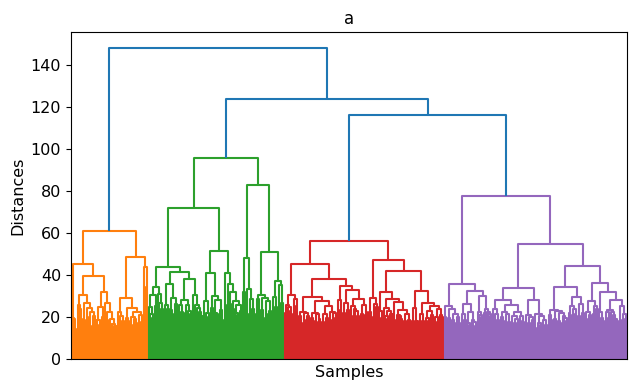

In [40]:
import scipy.cluster.hierarchy as sch

linkage_matrix = sch.linkage(all_metastatic_matrix.T, method='ward')

fig_height = 4
fig_width = fig_height * 1.618
fontsize = 11.5
plt.figure(figsize=(fig_width, fig_height))
sch.dendrogram(linkage_matrix, no_labels=True);
plt.ylabel('Distances', fontsize=fontsize)
plt.xlabel('Samples', fontsize=fontsize)
plt.title('a')
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

path =  os.path.join('figures_tables', f'Fig_5a.pdf')
plt.savefig(path)

In [14]:
from sklearn.decomposition import PCA
Y = all_metastatic_matrix.T
# PCA class
pca = PCA(6)
# Tissues as samples and pathways as features
pca.fit(Y)
# PCA transformation matrix
P_matrix = pca.transform(Y)

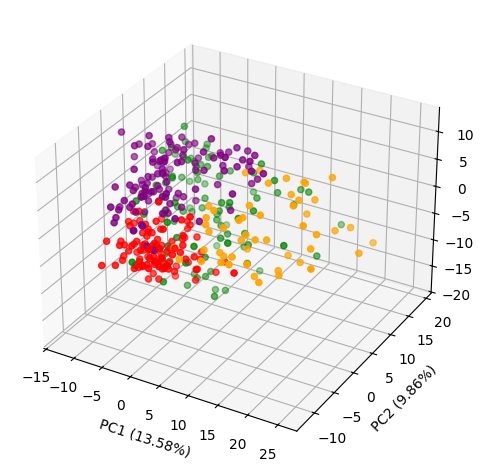

In [ ]:
th = 0.7 * max(linkage_matrix[:, 2])
clusters = sch.fcluster(linkage_matrix, t=th, criterion='distance')

colors = {1:'orange', 2: 'green', 3: 'red', 4: 'purple'}
color = [colors[i] for i in clusters]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Scatterplot 
ax.scatter(P_matrix[:, 0], P_matrix[:, 1], P_matrix[:, 2], c=color)

# The axes labels
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')

plt.tight_layout()

path =  os.path.join('figures_tables', f'Suppl_Fig_2.pdf')
plt.savefig(path)

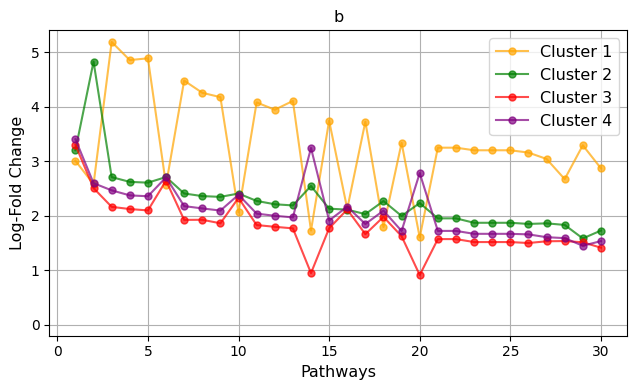

In [37]:

y1 = all_metastatic_pathw.pathway_data.loc[table2_.iloc[:30].PathwayName].iloc[:, np.argwhere(clusters==1)[:, 0]].mean(axis=1).to_numpy()
y2 = all_metastatic_pathw.pathway_data.loc[table2_.iloc[:30].PathwayName].iloc[:, np.argwhere(clusters==2)[:, 0]].mean(axis=1).to_numpy()
y3 = all_metastatic_pathw.pathway_data.loc[table2_.iloc[:30].PathwayName].iloc[:, np.argwhere(clusters==3)[:, 0]].mean(axis=1).to_numpy()
y4 = all_metastatic_pathw.pathway_data.loc[table2_.iloc[:30].PathwayName].iloc[:, np.argwhere(clusters==4)[:, 0]].mean(axis=1).to_numpy()

x = range(1, 31)

colors = {1:'orange', 2: 'green', 3: 'red', 4: 'purple'}
alpha_val = 0.7

fig_height = 4
fig_width = fig_height * 1.618
fontsize = 11.5
plt.figure(figsize=(fig_width, fig_height))

plt.plot(x, y1, 'o-', ms=5, label='Cluster 1', color=colors[1], alpha=alpha_val)
plt.plot(x, y2, 'o-', ms=5, label='Cluster 2', color=colors[2], alpha=alpha_val)
plt.plot(x, y3, 'o-', ms=5, label='Cluster 3', color=colors[3], alpha=alpha_val)
plt.plot(x, y4, 'o-', ms=5, label='Cluster 4', color=colors[4], alpha=alpha_val)

plt.ylabel('Log-Fold Change', fontsize=fontsize)
plt.xlabel('Pathways', fontsize=fontsize)
plt.title('b', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid()
ylim = plt.ylim()
ylim = [-0.2, ylim[1]]
plt.ylim(ylim)
plt.tight_layout()

path = os.path.join('figures_tables', f'Fig_5b.pdf')
plt.savefig(path)

### PCA - Gene Expression

In [17]:
genes_list = all_metastatic_pathw.gene_expression.index.to_numpy()

tumor_mask  = (all_metastatic_pathw.metadata.iloc[:, 1] == 'Primary Tumor')
tumor_sample = all_metastatic_pathw.metadata[tumor_mask].iloc[:, 0]
tumor_data = all_metastatic_pathw.gene_expression[tumor_sample] + 0.1

metastatic_mask = ~tumor_mask
metastatic_sample = all_metastatic_pathw.metadata[metastatic_mask].iloc[:, 0]
metastatic_data = all_metastatic_pathw.gene_expression[metastatic_sample] + 0.1

ref = gmean(tumor_data, axis=1)
metastatic_fc = np.log2(np.concatenate([tumor_data.T, metastatic_data.T]) / ref)

U, s, Vt = np.linalg.svd(metastatic_fc, full_matrices=False)
eigenvalues: np.ndarray = s**2/metastatic_fc.shape[0]
eigenvalues_normalized: np.ndarray = eigenvalues / eigenvalues.sum()
eigenvectors: np.ndarray= Vt
projection: np.ndarray = np.dot(Vt, metastatic_fc.T)

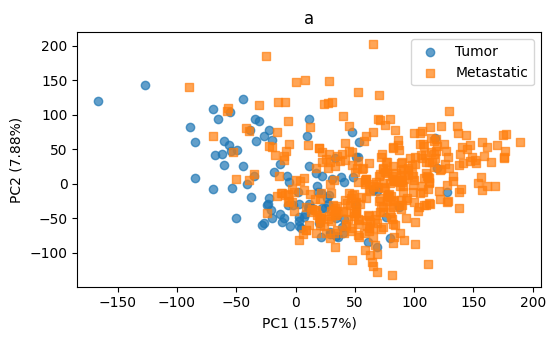

In [29]:
c1 = tumor_data.shape[1]

alpha_value = 0.7

fig_height = 3.5
fig_width = fig_height * 1.618
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

ax.scatter(projection[0, :c1], projection[1, :c1], label="Tumor",
           alpha=alpha_value)
    
ax.scatter(projection[0, c1:], projection[1, c1:], label="Metastatic",
           marker='s', alpha=alpha_value)

ax.set_xlabel(f'PC1 ({eigenvalues_normalized[0]*100:.2f}%)')
ax.set_ylabel(f'PC2 ({eigenvalues_normalized[1]*100:.2f}%)')
ax.set_title('a')
ax.legend()
plt.tight_layout()


path = os.path.join('figures_tables', f'Fig_4a.pdf')
plt.savefig(path, bbox_inches='tight')

### Violin Plots

In [19]:
def violin_fig(primary: np.ndarray, metast: np.ndarray, genes, symbols: np.ndarray, fname: str = None):
    fig1d, ax1d = plt.subplots()
    
    gene_id = []
    gene_name = []
    for name, ensembl in genes.items():
        gene_id.append(np.argwhere(symbols == ensembl)[0, 0])
        gene_name.append(name)
    
    n_genes = len(gene_id)

    groups = (['Primary tumor'] * primary.shape[0] * n_genes
              + ['Metastatic'] * metast.shape[0] * n_genes)
    
    columns_primary = np.concatenate([primary[:, gid] for gid in gene_id])
    columns_metast = np.concatenate([metast[:, gid] for gid in gene_id])
    columns = np.concatenate([
        columns_primary,
        columns_metast,
    ])
    
    categories = []
    for gn in gene_name:
        categories += [gn] * primary.shape[0]
    for gn in gene_name:
        categories += [gn] * metast.shape[0]

    sns.violinplot(x=groups, y=columns, hue=categories, inner='quart', ax=ax1d)
    ax1d.set_ylabel('$log_2(e/e_{ref})$')

    if fname:
        path = os.path.join('figures_tables', fname)
        fig1d.savefig(path, bbox_inches='tight')

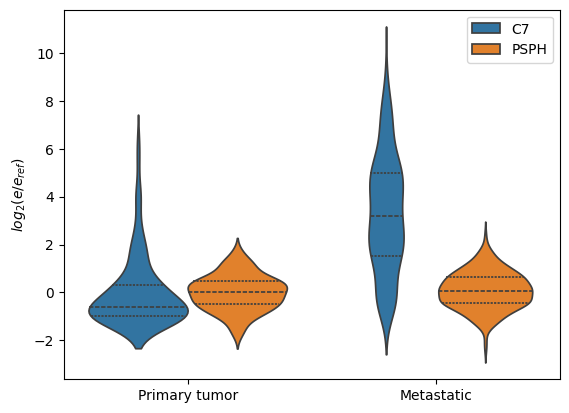

In [ ]:
c1 = tumor_data.shape[1]

gtarget = {
    'C7': 'ENSG00000112936',  # C7
    'PSPH': 'ENSG00000146733',  # PSPH
}

violin_fig(metastatic_fc[:c1], metastatic_fc[c1:], gtarget, genes_list, 'Suppl_Fig_1.pdf')

## Showing there is not correlation beetwen the fold change and the number of genes in each pathway

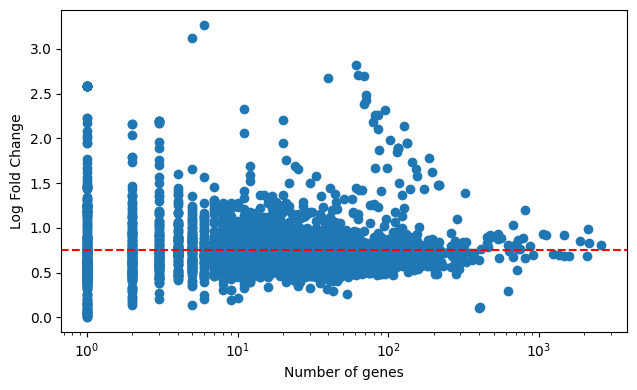

In [ ]:
all_metastatic_fc = all_metastatic_pathw.fold_change.loc[all_metastatic_pathw.common_genes]
all_metastatic_ref = all_metastatic_fc.abs().mean(axis=None)

fig_height = 4
fig_width = fig_height * 1.618
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

plt.plot(table2['Number of Genes'], table2['Expression'], 'o')
plt.axhline(all_metastatic_ref, color='red', linestyle='dashed')
plt.xlabel('Number of genes')
plt.ylabel('Log Fold Change')
plt.xscale('log')
plt.tight_layout()

path = os.path.join('figures_tables', 'suppl_Fig_3.pdf')
plt.savefig(path)
